In [50]:
import numpy as np

import matplotlib.pyplot as plt
from plotnine import * 
import pandas as pd
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

# Step 1:

In [84]:
class TreeCell(Agent):

    def __init__(self, model, pos):
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Empty"
        self.age = 0
        self.sinceburned = 0
        
    def step(self):
        if self.condition == "Burned Out":
            self.sinceburned += 1
            if self.sinceburned > self.model.decaytime:
                self.condition = "Empty"
        if self.condition == "Fine":
            self.age += 1
            if self.age == self.model.lifetime:
                neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
                count = 0
                for neighbor in neighbors:
                    if neighbor.condition == "Empty" and count < 2:
                        neighbor.condition = "Fine"
                        neighbor.age = 0
                        count += 1
                self.condition = "Empty"
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

In [94]:
class ForestFire(Model):

    def __init__(self, height, width, density, decaytime):
        self.lifetime = 10
        self.decaytime = decaytime
        self.height = height
        self.width = width
        self.density = density
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out"),
                                "Empty": lambda m: self.count_type(m, "Empty")})
        
        for x in range(self.width):
            for y in range(self.height):
                new_tree = TreeCell(self, (x, y))
                if self.random.random() < self.density:
                    new_tree.condition = "Fine"
                    new_tree.age = self.random.randint(1,self.lifetime)
                if x == 0:
                    new_tree.condition = "On Fire"
                self.grid[y][x] = new_tree
                self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        self.schedule.step()
        self.dc.collect(self)
        if self.schedule.time > 200:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

In [95]:
fire = ForestFire(100, 100, 0.6, 5)

In [96]:
fire.run_model()

In [97]:
results = fire.dc.get_model_vars_dataframe()

In [98]:
results

,Fine,On Fire,Burned Out,Empty
0,5934,94,197,3775
1,5978,71,352,3599
2,6038,59,469,3434
3,6125,62,567,3246
4,6148,73,686,3093
...,...,...,...,...
196,7162,0,0,2838
197,7162,0,0,2838
198,7167,0,0,2833
199,7181,0,0,2819


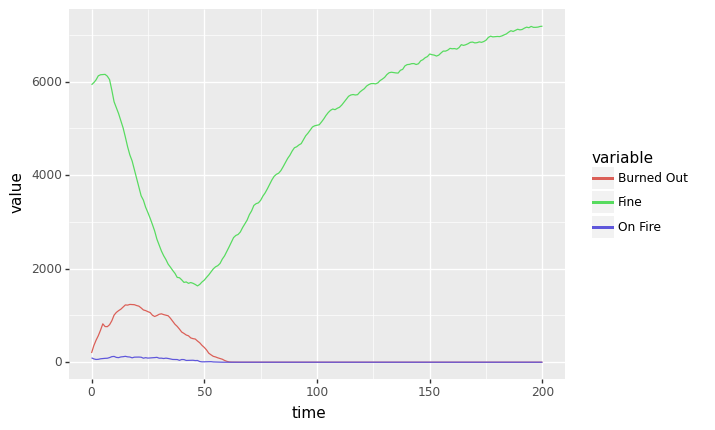

<ggplot: (112897020558)>

In [99]:
results["time"] = np.linspace(0, len(results) - 1, len(results))
resultsmelt = pd.melt(results, id_vars=["time"], value_vars=["Fine", "On Fire", "Burned Out"])
ggplot(resultsmelt, aes(x="time", y="value", color="variable")) \
+ geom_line()

In [118]:
fixed_params = dict(height=50, width=50, density = 0.6)
variable_params = dict(decaytime=np.linspace(0,60,31)[1:])

model_reporter = {"Fine": lambda m: (ForestFire.count_type(m, "Fine") / m.schedule.get_agent_count()) }

In [119]:
param_run = BatchRunner(ForestFire, variable_parameters=variable_params, 
                        fixed_parameters=fixed_params, iterations = 4, model_reporters=model_reporter)

In [120]:
param_run.run_all()

120it [02:21,  1.18s/it]


In [121]:
df = param_run.get_model_vars_dataframe()

In [122]:
df.head()

,decaytime,Run,Fine,height,width,density
0,2.0,0,0.7320,50,50,0.6
1,2.0,1,0.7240,50,50,0.6
2,2.0,2,0.6796,50,50,0.6
3,2.0,3,0.7460,50,50,0.6
4,4.0,4,0.7088,50,50,0.6


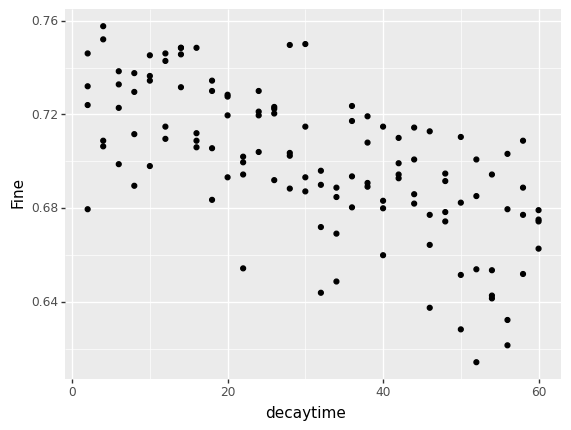

<ggplot: (112894230384)>

In [123]:
ggplot(df, aes(x="decaytime", y="Fine")) \
+ geom_point()

# Step 2: